<a href="https://colab.research.google.com/github/Yospy/Timeseries-forecasting-for-weather-prediction/blob/main/TimeSeries_forecasting_for_weather_predcition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from numpy import *
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from zipfile import ZipFile
import os

url =  "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zp = tf.keras.utils.get_file(origin=url,fname="jena_climate_2009_2016.csv.zip")
zf = ZipFile(zp)
zf.extractall()
csvp = "jena_climate_2009_2016.csv"

df = pd.read_csv(csvp)
df

13582336/13568290 [==============================] - 0s 0us/step


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


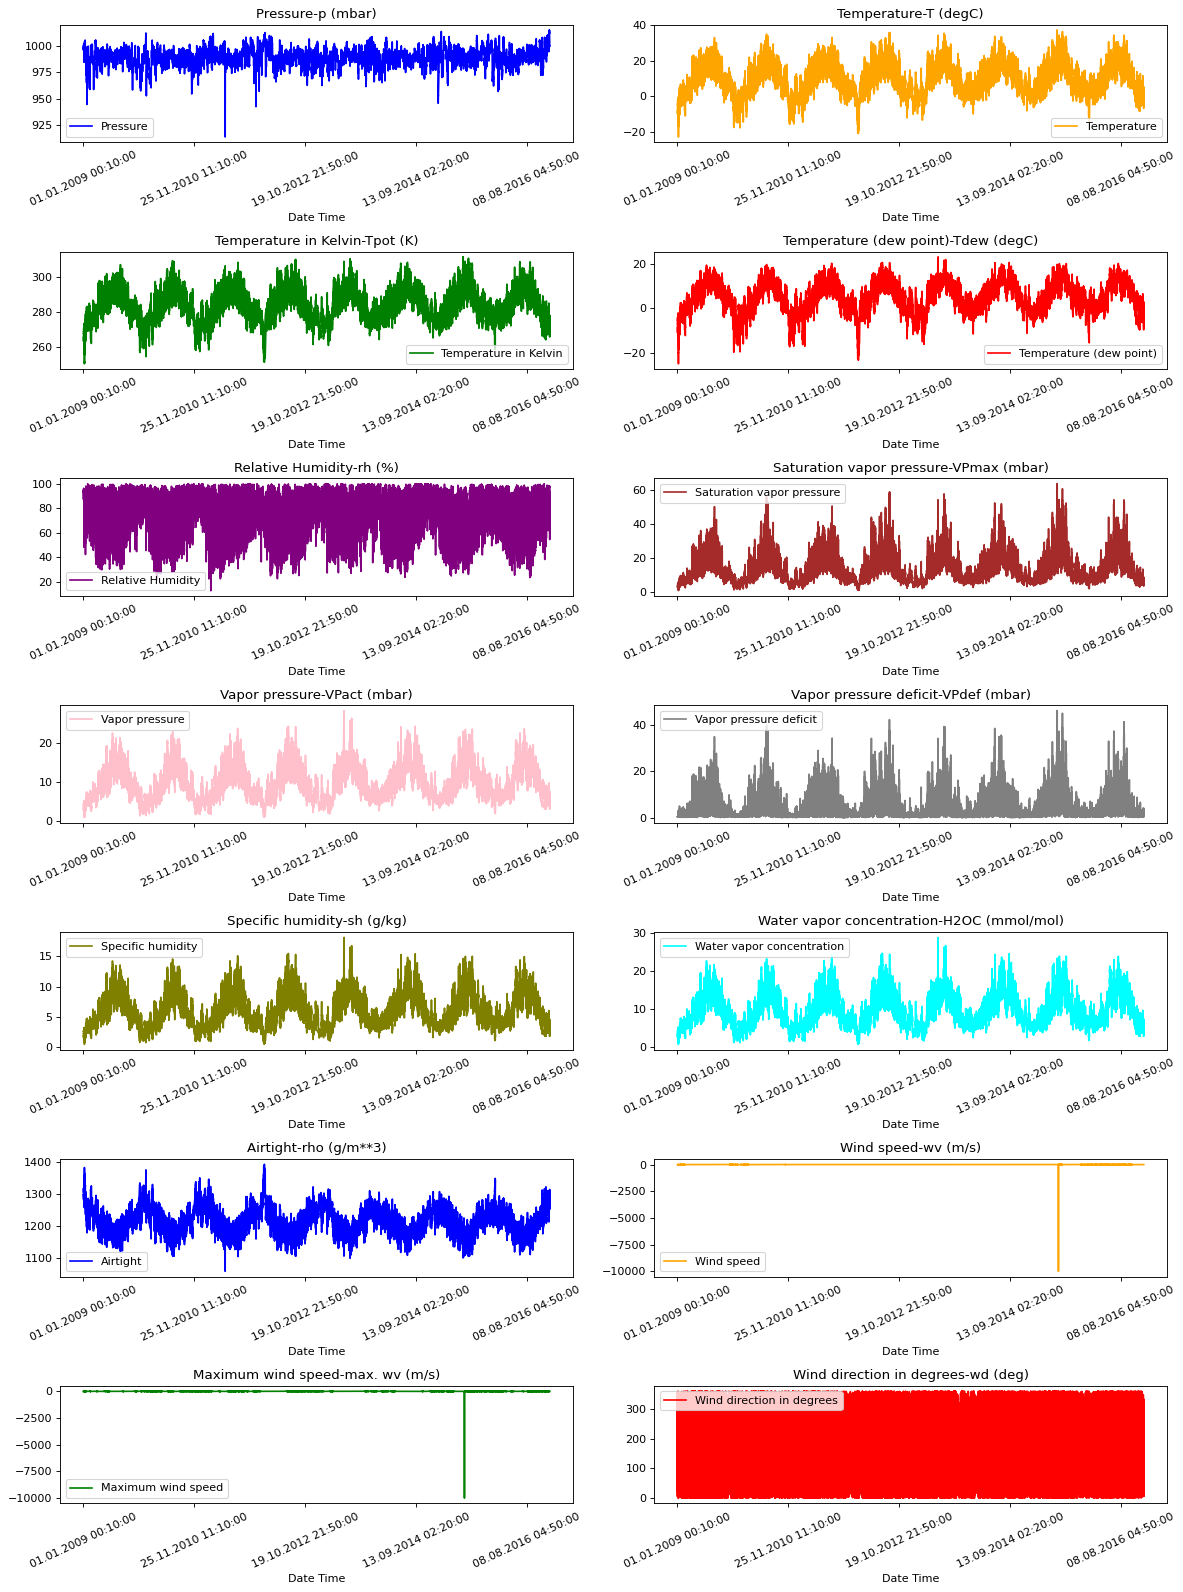

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

def srv(data):
  time_data = data[date_time_key]
  fig, axes = plt.subplots(nrows=7,ncols=2,figsize=(15,20),dpi=80,facecolor="w",edgecolor="k")
  for i in range(len(feature_keys)):
    key = feature_keys[i]
    c = colors[i%(len(colors))]
    t_data = data[key]
    t_data.index = time_data
    t_data.head()
    ax = t_data.plot(
        ax=axes[i // 2,i%2],
        color=c,
        title="{}-{}".format(titles[i], key),
        rot = 25,
    )
    ax.legend([titles[i]])
  plt.tight_layout()

srv(df)


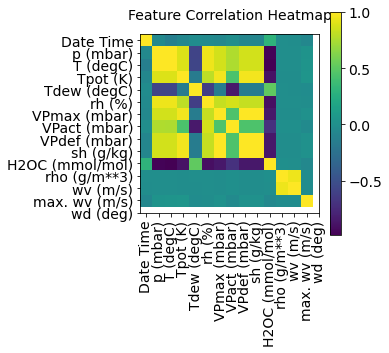

In [4]:
def heatmap_s(data):
  plt.matshow(data.corr())
  plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
  plt.gca().xaxis.tick_bottom()
  plt.yticks(range(data.shape[1]),data.columns, fontsize=14)

  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  plt.title("Feature Correlation Heatmap", fontsize=14)
  plt.show()

heatmap_s(df)

In [5]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
lr = 0.001
bs = 256
epochs = 10

def normalise(data, train_split):
  data_mean = data[:train_split].mean(axis=0)
  data_std = data[:train_split].std(axis=0)
  return (data - data_mean) / data_std

In [6]:
print("The selected parameters are:",
      ", ".join([titles[i] for i in [0,1,5,7,8,10,11]]),
)
selected_features = [feature_keys[i] for i in [0,1,5,7,8,10,11]]
features = df[selected_features]
features.index = df[date_time_key]

features = normalise(features.values, train_split)
features = pd.DataFrame(features)

train_data = features.loc[0:train_split-1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [7]:
start = past + future
end = start + train_split

X_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]


sequence_length = int(past/step)

In [8]:
data_train = tf.keras.preprocessing.timeseries_dataset_from_array(X_train, y_train, sequence_length=sequence_length, sampling_rate=step, batch_size=bs)

In [9]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

X_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

val_data = tf.keras.preprocessing.timeseries_dataset_from_array(X_val, y_val, 
                                                                sequence_length=sequence_length, sampling_rate=step, batch_size=bs)

for batch in data_train.take(1):
  inputs, targets = batch

print("Input Shape: ", inputs.numpy().shape)
print("Target Shape: ", targets.numpy().shape)


Input Shape:  (256, 120, 7)
Target Shape:  (256, 1)


In [10]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [11]:
ck = "model_checkpoint.h5"
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5)

modelcp = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath = ck,
    verbose=1,
    save_weights_only=True,
    save_best_only = True
)

history = model.fit(data_train, epochs=epochs, validation_data=val_data, callbacks=[cb, modelcp])

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2111
Epoch 1: val_loss improved from inf to 0.15769, saving model to model_checkpoint.h5
1172/1172 [==============================] - 256s 216ms/step - loss: 0.2111 - val_loss: 0.1577
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1285
Epoch 2: val_loss improved from 0.15769 to 0.13108, saving model to model_checkpoint.h5
1172/1172 [==============================] - 273s 233ms/step - loss: 0.1285 - val_loss: 0.1311
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1154
Epoch 3: val_loss did not improve from 0.13108
1172/1172 [==============================] - 195s 166ms/step - loss: 0.1154 - val_loss: 0.1320
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1106
Epoch 4: val_loss did not improve from 0.13108
1172/1172 [==============================] - 179s 153ms/step - loss: 0.1106 - val_loss: 0.1347
Epoch 5/10
1172/1172 [================

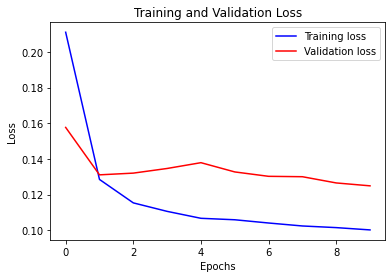

In [12]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

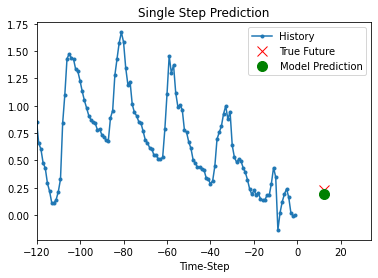

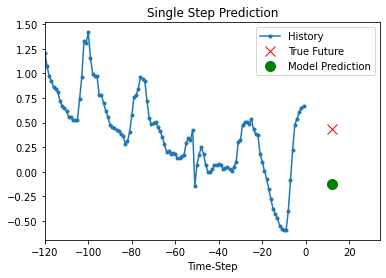

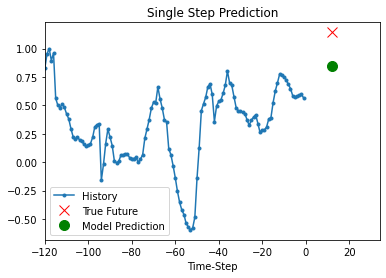

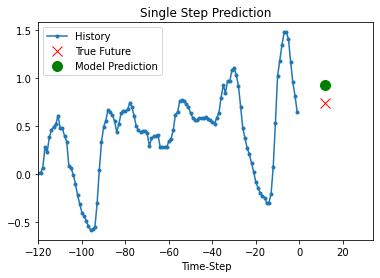

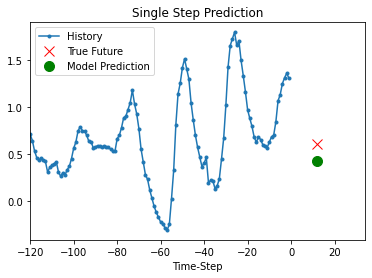

In [14]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in val_data.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )